### Table of content
1. What is Stegnography
2. About the Dataset
3. Evaluation Metric
4. Image Analysis
5. DCT Coefficients

**This notebook helped me a lot in evaluation metric calculation. Please upvote this kernel also**
https://www.kaggle.com/anokas/weighted-auc-metric-updated

If you find my work helpful then do upvote. Let's start

# 1. What is Stegnography

**Steganography is the technique of hiding secret data within an ordinary, non-secret, file or message in order to avoid detection; the secret data is then extracted at its destination. The use of steganography can be combined with encryption as an extra step for hiding or protecting data. In most of the cases hidden messages are concealed within the lowest bits of noisy images. For example if a color is represented in 8 bits then first 6 bits can be used for image and last 2 bits can be used to embed hidden message**

Here is the visual example of stegnograpy. Same image viewed by white, blue green and red shows different numbers.

![](https://upload.wikimedia.org/wikipedia/en/thumb/9/9c/Steganography.png/310px-Steganography.png)

Image Source: Wikipedia

# 2. About the Dataset

This dataset contains a large number of unaltered images, called the "Cover" image, as well as corresponding examples in which information has been hidden using one of three steganography algorithms (JMiPOD, JUNIWARD, UERD). The goal of the competition is to determine which of the images in the test set (Test/) have hidden messages embedded.

Note that in order to make the competition more realistic the length of hidden messages (the payload) will not be provided. The only available information on the test set is:

1. Each embedding algorithm is used with the same probability.
2. The payload (message length) is adjusted such that the "difficulty" is approximately the same regardless the content of the image. Images with smooth content are used to hide shorter messages while highly textured images will be used to hide more secret bits. The payload is adjusted in the same manner for testing and training sets.
3. The average message length is 0.4 bit per non-zero AC DCT coefficient.
4. The images are all compressed with one of the three following JPEG quality factors: 95, 90 or 75.


75k images are povided in each of Cover, JMiPOD, JUNIWARD, UERD directories. 5k images are provided in test data.

1. Cover/ contains 75k unaltered images meant for use in training.
2. JMiPOD/ contains 75k examples of the JMiPOD algorithm applied to the cover images.
3. JUNIWARD/contains 75k examples of the JUNIWARD algorithm applied to the cover images.
4. UERD/ contains 75k examples of the UERD algorithm applied to the cover images.
5. Test/ contains 5k test set images. These are the images for which you are predicting.
6. sample_submission.csv contains an example submission in the correct format.

# 3. Evaluation Metric

Here the evaluation metric is weighted AUC. In other words, the area between the true positive rate of 0 and 0.4 is weighted 2X, the area between 0.4 and 1 is now weighed (1X). The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1. 

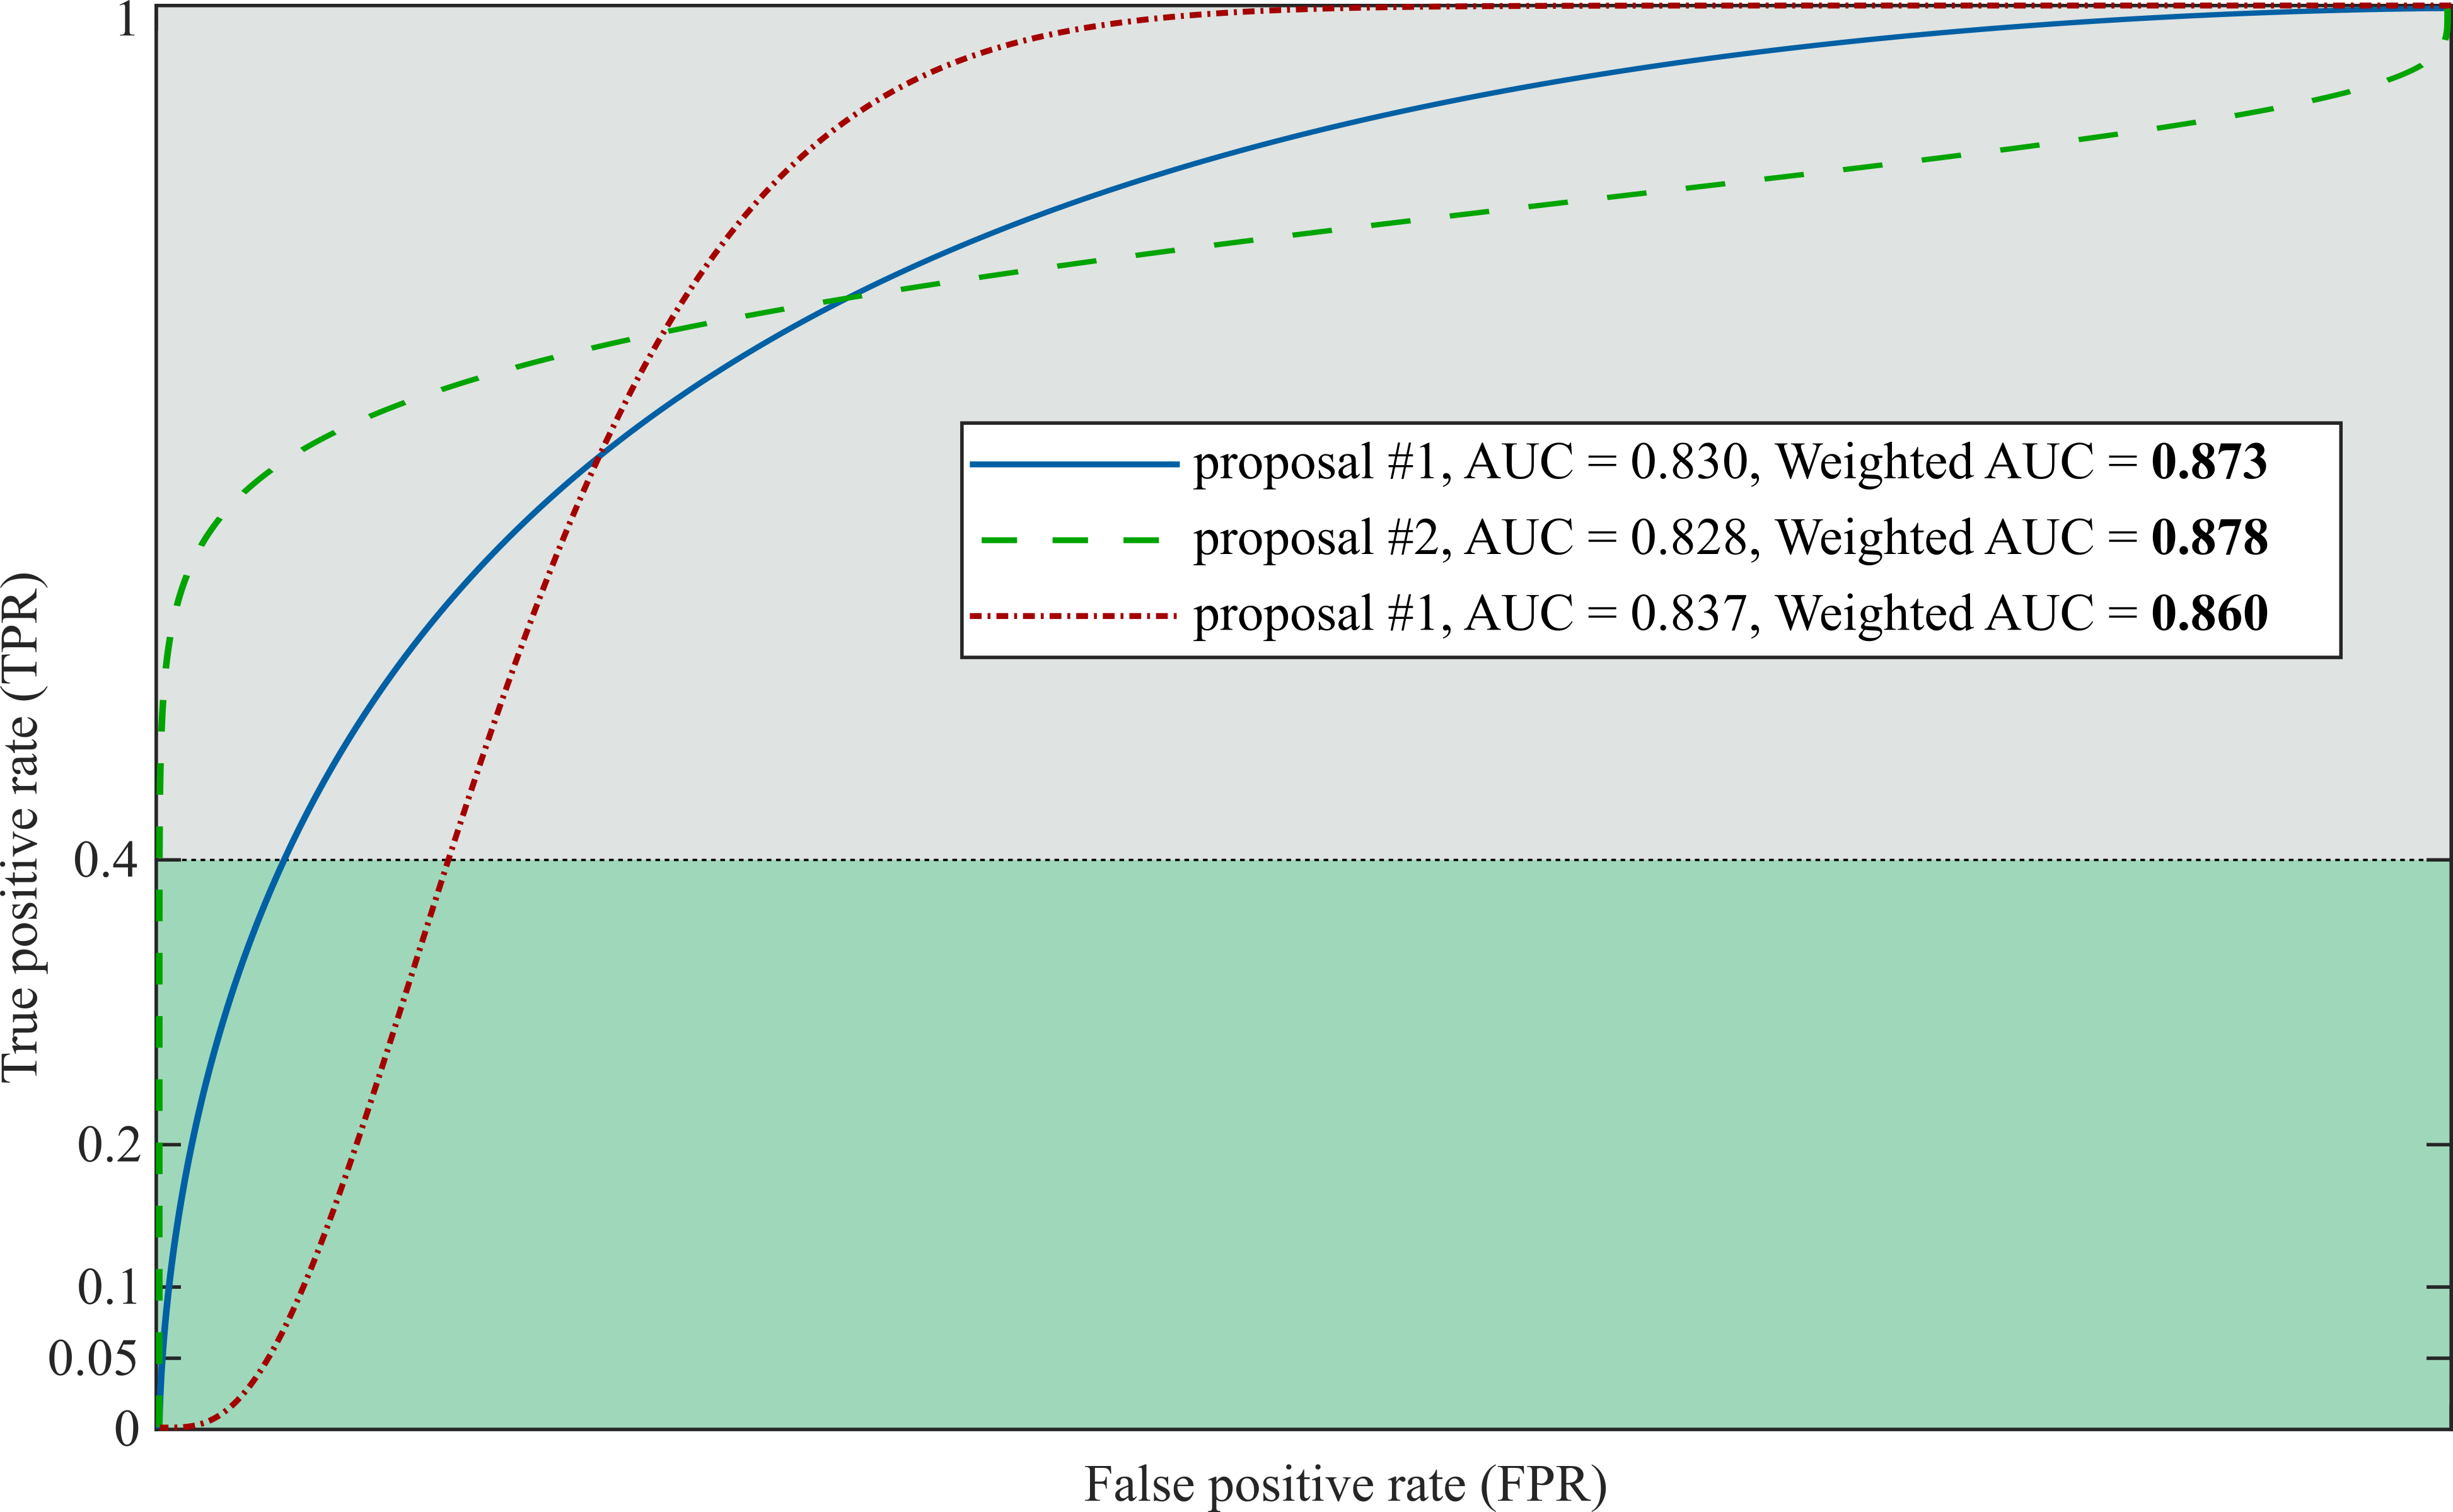

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import os
import matplotlib.image as mpimg
import glob
from PIL import Image 

**Let's make evaluation metric**
Logic for making evaluation metric:
First keeping 0.4 True positive rate as threshold i will calculate area under the curve (x ∈ [0, 1], y ∈ [0, 0.4]), 0.4 being a horizontal line. Multiply the AUC with the weight (2X), Similarly from (x ∈ [0, 1], y ∈ [0.4, 1.0]), taking y = 0.4 as origin i will calculate the area under the curve. Multiply the AUC with weight (1X). After this i will add both AUC and divide by 1.4 (0.4 * 2 + 0.6 * 1) for normalizing.

In [22]:
# Given Data
tpr_thresholds = [0.0, 0.4, 1.0]
weights =        [       2,   1]

def weighted_auc(labels, preds, plot = False):
    # Calculating ROC curve
    fpr, tpr, _ = roc_curve(labels, preds, pos_label=1)
    # data labels, preds
    area = np.array(tpr_thresholds)[1:] - np.array(tpr_thresholds)[:-1]
    area_normalized = np.dot(area, np.array(weights).T)  # For normalizing AUC
    fscore = 0
    for index, weight in enumerate(weights):
        ymin = tpr_thresholds[index]    
        ymax = tpr_thresholds[index + 1]

        mask = (tpr > ymin) & (tpr < ymax)
        x = np.concatenate([fpr[mask], np.linspace(fpr[mask][-1], 1, 100)])
        y = np.concatenate([tpr[mask], [ymax] * 100])
        y = y #(taking y as origin)
        score = auc(x, y-ymin)
        # Multiply score with weight
        weighted_score = score * weight

        fscore += weighted_score
        color = ["red", "green"]
        label = ["x ∈ [0, 1], y ∈ [0, 0.4]", "x ∈ [0, 1], y ∈ [0.4, 1.0]"]
        
        if plot:
            plt.title("Separate plots for x ∈ [0, 1], y ∈ [0, 0.4] and x ∈ [0, 1], y ∈ [0.4, 1.0]")
            plt.plot(x, y, color = color[index], label = label[index])
            plt.xlabel("False Positive rate")
            plt.ylabel("True Positive rate")
            plt.legend(loc = 2)
#             plt.plot()

    # Normalizing score
    final_score = fscore/area_normalized
    return final_score
    
    

In [23]:
# Initializing random labels and prediction to simulate the metric
np.random.seed(42)

signal = np.random.random(1000)
labels = (signal > 0.5).astype(int)
preds = np.random.random(1000) + (signal - 0.5) * 0.3

0.7243803634073684

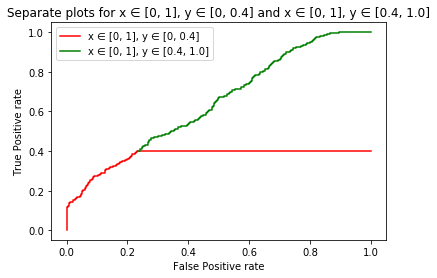

In [24]:
weighted_auc(labels, preds, plot = True)

# 4. Image Analysis

As per the discussion:
https://www.kaggle.com/c/alaska2-image-steganalysis/discussion/147494

**Data is hidden in DCT coefficients not in the pixels. There are some changes in pixel values which is only due to embedding of message. Below i have plotted the difference between pixel values in cover and stego images. Let's have a look
**

In [29]:
# path to images
BASE_PATH = "../input/alaska2-image-steganalysis"
train_images_name = os.listdir(BASE_PATH + "/Cover")
test_images_name = os.listdir(BASE_PATH + "/Test")
train_images_name.sort(), test_images_name.sort()
print(f"Number of images in train set are {len(train_images_name)}")
print(f"Number of images in test set are {len(test_images_name)}")

Number of images in train set are 75000
Number of images in test set are 5000


**In this competition we are provided with embedded images having different embedding techniques like JMiPOD, JUNIWARD, UERD. We have to look for what knind of changes these algorithms make to original images by analysing RGB values of Cover images and embedded images. Let's look at the first image in Cover, JMiPOD, JUNIWARD, UERD directories**

In [30]:
cover_image = mpimg.imread(os.path.join(BASE_PATH, "Cover/00004.jpg"))
JMiPOD_image = mpimg.imread(os.path.join(BASE_PATH, "JMiPOD/00004.jpg"))
JUNIWARD_image = mpimg.imread(os.path.join(BASE_PATH, "JUNIWARD/00004.jpg"))
UERD_image = mpimg.imread(os.path.join(BASE_PATH, "UERD/00004.jpg"))

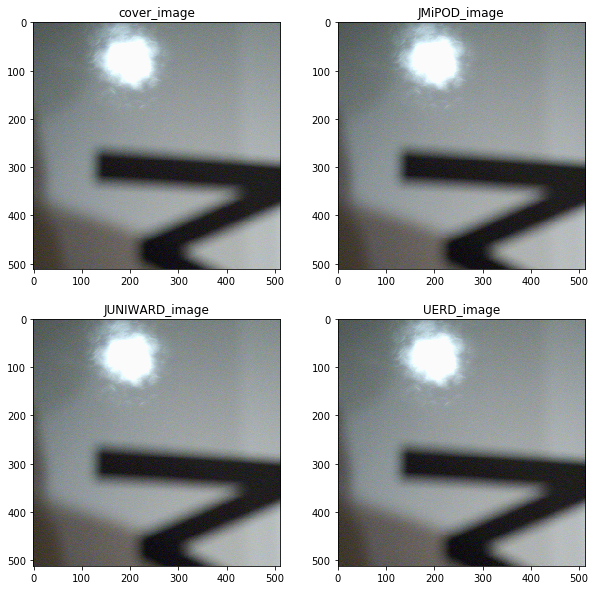

In [31]:
plt.figure(1, figsize = (10, 10))
plt.subplot(221)
plt.title("cover_image")
plt.imshow(cover_image)

plt.subplot(222)
plt.imshow(JMiPOD_image)
plt.title("JMiPOD_image")

plt.subplot(223)
plt.imshow(JUNIWARD_image)
plt.title("JUNIWARD_image")

plt.subplot(224)
plt.imshow(UERD_image)
plt.title("UERD_image")
plt.show()

**Well above all images look exactly similar but except the first image all the other images have secret code, SCARY**

Let's analyse each image

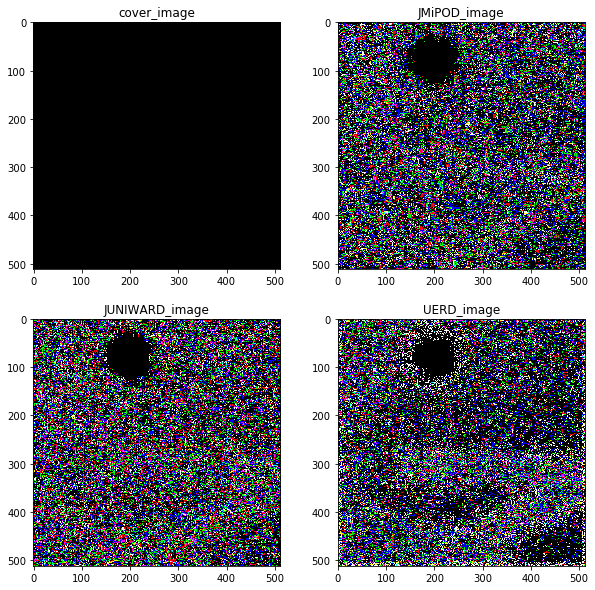

In [32]:
plt.figure(1, figsize = (10, 10))
plt.subplot(221)
plt.title("cover_image")
plt.imshow(cover_image - cover_image)

plt.subplot(222)
plt.imshow(JMiPOD_image - cover_image)
plt.title("JMiPOD_image")

plt.subplot(223)
plt.imshow(JUNIWARD_image - cover_image)
plt.title("JUNIWARD_image")

plt.subplot(224)
plt.imshow(UERD_image - cover_image)
plt.title("UERD_image")
plt.show()

We can see that there is change in pixel values in each of the embedded image when compared with cover image

# 5. DCT (Discrete Cosine Transform) coefficients

So What is DCT?

To understand DCT first you need to understand about spatial domain and frequency domain.
Spatial Domain and Frequency Domain are image enhancement techniques. Let's talk about each of them.

Spatial Domain: Spatial Domain techniques deals with image pixels. The pixel values are manipulated to achieve desired enhancements.

Frequency Domain: These techniques are based on the manipulation of orthogonal transform of image rather than image itself for e.g change in phase, amplitude.

In DCT, Image from spatial domain is converted to frequency domain

![](https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/fig2.gif)

In the above diagram spatial domain image f(i, j) is converted to frequency domain F(u, v) using DCT

The formuls for DCT is given below:
![](https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/img28.gif)
Where:
![](https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/img29.gif)
                                                    N, M are dimensions of imput image in 2d
                                                    
                                                    
                                                    
For more details you can use below link:

https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/node231.html

Let'a apply DCT to input images

You can refer this tutorial on Github for DCT

https://github.com/dwgoon/jpegio/blob/master/examples/jpegio_tutorial.ipynb

In [26]:
! git clone https://github.com/dwgoon/jpegio
!pip install jpegio/.
import jpegio as jio

fatal: destination path 'jpegio' already exists and is not an empty directory.
Processing ./jpegio
  Created wheel for jpegio: filename=jpegio-0.2.1-cp37-cp37m-linux_x86_64.whl size=1037613 sha256=91fa38845064c8aa0a689c6388320c9a2afd404d0652aca849dd5fc812603b92
  Stored in directory: /tmp/pip-ephem-wheel-cache-5uba4uxr/wheels/63/fa/8a/228404b42bb02e7b206de3032473b06abde4aa1058d2d0254e
Successfully built jpegio
  Attempting uninstall: jpegio
    Found existing installation: jpegio 0.2.1
    Uninstalling jpegio-0.2.1:
      Successfully uninstalled jpegio-0.2.1


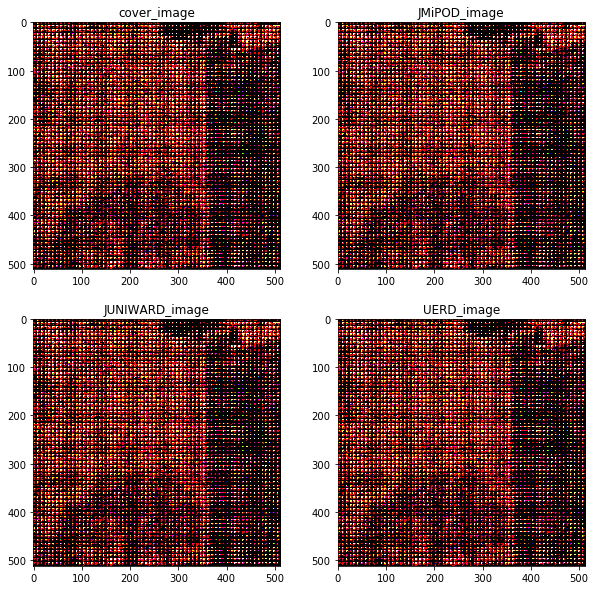

In [28]:
coverDir = "/kaggle/input/alaska2-image-steganalysis/Cover/00001.jpg"
JMiPODDir = "/kaggle/input/alaska2-image-steganalysis/JMiPOD/00001.jpg"
JUNIWARDDir = "/kaggle/input/alaska2-image-steganalysis/JUNIWARD/00001.jpg"
UERDDir = "/kaggle/input/alaska2-image-steganalysis/UERD/00001.jpg"



#imgList = sorted(os.listdir(coverDir))
# imgList = os.listdir(coverDir)[:20]
# random.shuffle(imgList)
plt.figure(1, figsize = (10, 10))
plt.subplot(221)
plt.title("cover_image")
c_struct=jio.read(coverDir)
coverDCT = np.zeros([512,512,3])
coverDCT[:,:,0] = c_struct.coef_arrays[0]
coverDCT[:,:,1] = c_struct.coef_arrays[1]
coverDCT[:,:,2] = c_struct.coef_arrays[2]
coverQTbl = c_struct.quant_tables[0]
plt.imshow( abs(coverDCT) )

plt.subplot(222)
plt.title("JMiPOD_image")
c_struct=jio.read(JMiPODDir)
JMiPODDirDCT = np.zeros([512,512,3])
JMiPODDirDCT[:,:,0] = c_struct.coef_arrays[0]
JMiPODDirDCT[:,:,1] = c_struct.coef_arrays[1]
JMiPODDirDCT[:,:,2] = c_struct.coef_arrays[2]
JMiPODDirQTbl = c_struct.quant_tables[0]
plt.imshow( abs(JMiPODDirDCT) )

plt.subplot(223)
plt.title("JUNIWARD_image")
c_struct=jio.read(JUNIWARDDir)
JUNIWARDDirDCT = np.zeros([512,512,3])
JUNIWARDDirDCT[:,:,0] = c_struct.coef_arrays[0]
JUNIWARDDirDCT[:,:,1] = c_struct.coef_arrays[1]
JUNIWARDDirDCT[:,:,2] = c_struct.coef_arrays[2]
JUNIWARDDirQTbl = c_struct.quant_tables[0]
plt.imshow( abs(JUNIWARDDirDCT) )


plt.subplot(224)
plt.title("UERD_image")
c_struct=jio.read(UERDDir)
UERDDirDCT = np.zeros([512,512,3])
UERDDirDCT[:,:,0] = c_struct.coef_arrays[0]
UERDDirDCT[:,:,1] = c_struct.coef_arrays[1]
UERDDirDCT[:,:,2] = c_struct.coef_arrays[2]
UERDDirQTbl = c_struct.quant_tables[0]
plt.imshow( abs(UERDDirDCT) )